<div style="color:#800080; font-size:28px; font-weight:bold;">
Título y datos del alumno    
</div>

**Título: Predecir la aparición de diabetes basándose en medidas de diagnóstico**
  
**Autores:**  
- Cisneros Lovaton, Sarai
- Urbina Castro, George

<div style="color:#800080; font-size:28px; font-weight:bold;">
    1. Introducción y Contexto del Negocio  
</div>

**Contexto**  
El Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales quiere predecir diagnósticamente si un paciente padece diabetes, basándose en ciertas mediciones diagnósticas. En particular, todos los pacientes aquí presentes son mujeres de al menos 21 años de ascendencia indígena pima.

**Definición de variables:**

Variables Predictoras:
- Pregnancies: Número de veces que quedó embarazada
- Glucose: Concentración de glucosa plasmática a las 2 horas en una prueba de tolerancia a la glucosa oral
- BloodPressure: Presión arterial diastólica (mm Hg)
- SkinThickness: Espesor del pliegue cutáneo del tríceps (mm)
- Insulin: Insulina sérica de 2 horas (mu U/ml)
- BMI: Índice de masa corporal (peso en kg/(altura en m)^2)
- DiabetesPedigreeFunction: Función del pedigrí de la diabetes
- Age: Edad (años) 

Variable Objetivo (Target):
- Outcome (0: No tiene diabetes / 1: Tiene diabetes)


**Pregunta de negocio que intentas responder:**  
¿Puede construir un modelo de aprendizaje automático para predecir con precisión si los pacientes en el conjunto de datos tienen diabetes o no?

<div style="color:#800080; font-size:28px; font-weight:bold;">
    2. Carga de datos y Preprocesamiento
</div>

In [1]:
# 1. Configuración Inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Agregado para visualizaciones
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, ConfusionMatrixDisplay
import joblib
import time
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import os
import kagglehub
import xgboost as xgb
from sklearn.svm import SVC

# Semilla aleatoria
RANDOM_STATE = 42

c:\Users\Usuario\miniconda3\envs\ml_pro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install kagglehub

In [3]:
# Cambiar ruta de almacenamiento
os.environ["KAGGLEHUB_CACHE"] = "../data/"
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Descargado en:", path)

Descargado en: ../data/datasets\uciml\pima-indians-diabetes-database\versions\1


In [4]:
df = pd.read_csv("../data/datasets/uciml/pima-indians-diabetes-database/versions/1/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Ver columnas disponibles
print("Columnas:", df.columns.tolist()[:10], "...")
print(f"Dimensiones: {df.shape}")

# Separar Features y Target(Outcome)
TARGET_COL = 'Outcome'
COLS_TO_DROP = [TARGET_COL]

# Eliminamos explícitamente columnas que no aportan valor predictivo o son identificadores.
X = df.drop([col for col in COLS_TO_DROP if col in df.columns], axis=1)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Distribución target (Train): {y_train.value_counts(normalize=True).to_dict()}")
print("")

X_train.info()


Columnas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'] ...
Dimensiones: (768, 9)

Train shape: (614, 8)
Test shape: (154, 8)
Distribución target (Train): {0: 0.6514657980456026, 1: 0.3485342019543974}

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 353 to 107
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 43.2 KB


<div style="color:#800080; font-size:28px; font-weight:bold;">
Explotación de Datos (EDA)
</div>

In [6]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas Numéricas detectadas:", num_cols)

# columnas que en Pima usan 0 como indicador implícito de NA
suspect_zero_cols = [c for c in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] if c in num_cols]
print("")
print("Columnas donde 0 puede significar missing:", suspect_zero_cols)
print("")
for c in suspect_zero_cols:
    zeros = (X_train[c] == 0).sum()
    print(f"  {c}: zeros = {zeros} ({zeros/len(X_train)*100:.2f}%)")

Columnas Numéricas detectadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Columnas donde 0 puede significar missing: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

  Glucose: zeros = 4 (0.65%)
  BloodPressure: zeros = 23 (3.75%)
  SkinThickness: zeros = 175 (28.50%)
  Insulin: zeros = 290 (47.23%)
  BMI: zeros = 9 (1.47%)


In [7]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,614.0,3.819218,3.314148,0.000,1.000,3.0000,6.00000,17.000
Glucose,614.0,120.908795,31.561093,0.000,99.000,117.0000,140.00000,199.000
BloodPressure,614.0,69.442997,18.402581,0.000,62.500,72.0000,80.00000,122.000
SkinThickness,614.0,20.776873,15.856433,0.000,0.000,23.0000,32.00000,99.000
Insulin,614.0,78.666124,107.736572,0.000,0.000,40.5000,130.00000,744.000
BMI,614.0,31.973290,7.861364,0.000,27.500,32.3000,36.50000,67.100
DiabetesPedigreeFunction,614.0,0.477428,0.330300,0.084,0.245,0.3825,0.63925,2.329
Age,614.0,33.366450,11.833438,21.000,24.000,29.0000,41.00000,81.000


In [8]:
# Identificar tipos de columnas automáticamente
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numéricas ({len(num_features)}): {num_features[:10]}...")
print(f"Features categóricas ({len(cat_features)}): {cat_features[:10] if cat_features else 'Ninguna'}")

# Verificar valores nulos
null_pct = (X_train.isnull().sum() / len(X_train)
            * 100).sort_values(ascending=False)
print(f"\nColumnas con más nulos:\n{null_pct.head()}")

Features numéricas (8): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']...
Features categóricas (0): Ninguna

Columnas con más nulos:
Pregnancies      0.0
Glucose          0.0
BloodPressure    0.0
SkinThickness    0.0
Insulin          0.0
dtype: float64


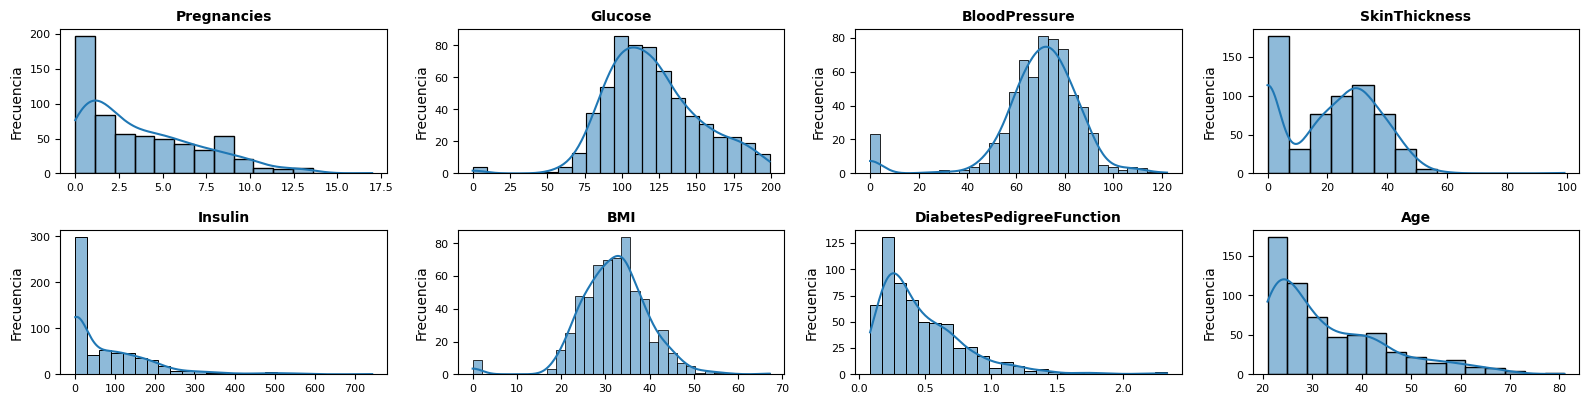

In [9]:
def plot_numeric_distributions(x):
    # Seleccionar columnas numéricas
    columnas_numeric = num_features #x.select_dtypes(include=['float64', 'int64']).columns

    # Número de variables numéricas
    num_vars = len(columnas_numeric)

    # Calcular el número de filas y columnas
    ncols = 4
    nrows = int(np.ceil(num_vars / ncols))

    # Crear subgráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 2))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil indexación

    # Graficar histogramas
    for i, colum in enumerate(columnas_numeric):
        sns.histplot(data=x, x=colum, kde=True, ax=axes[i])
        axes[i].set_title(colum, fontsize=10, fontweight="bold")
        axes[i].tick_params(labelsize=8)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frecuencia")

    # Ocultar ejes extra
    for ax in axes[num_vars:]:
        ax.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    #fig.suptitle('Distribución de variables numéricas', fontsize=12, fontweight="bold")
    plt.show()

plot_numeric_distributions(X_train)

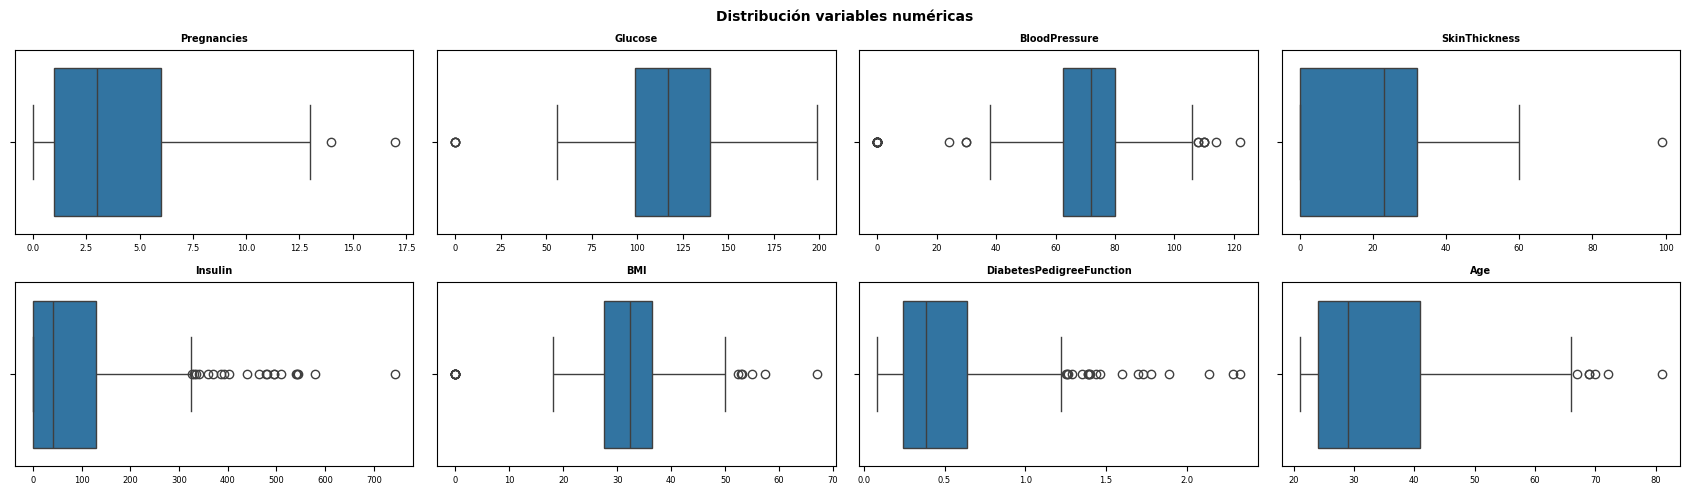

In [10]:
# Ajustar el número de subplots en función del número de columnas numéricas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))
axes = axes.flat
columnas_numeric = num_features #df.select_dtypes(include=['float64', 'int64']).drop(columns=['Outcome']).columns

for i, colum in enumerate(columnas_numeric):
    sns.boxplot(data=X_train, x=colum, ax=axes[i])
    axes[i].set_title(colum, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize=10, fontweight="bold")
plt.show()

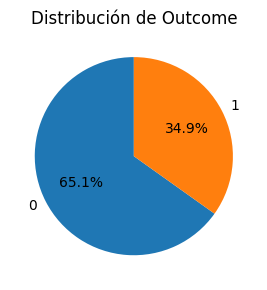

In [11]:
conteo = y_train.value_counts()

plt.figure(figsize=(3,3))
plt.pie(
    conteo.values,
    labels=conteo.index,
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Distribución de Outcome")
plt.tight_layout()
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
Preprocesamiento (Pipeline)
</div>

In [12]:
cols_validar_ceros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
cols_no_validar_ceros = ['Pregnancies','DiabetesPedigreeFunction','Age']

# Pipeline para columnas con ceros sospechosos
pipeline_ceros = Pipeline([
    ('imputer', SimpleImputer(missing_values=0, strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para columnas sin ceros sospechosos
pipeline_normales = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('pipeline_ceros', pipeline_ceros, cols_validar_ceros),
        ('pipeline_normales', pipeline_normales, cols_no_validar_ceros)
    ],
    verbose_feature_names_out=False,
    remainder='drop'  # Lo que no listamos, se borra
)

# Visualizar el preprocesador (sin ajustar aún)
preprocessor

,transformers,"[('pipeline_ceros', ...), ('pipeline_normales', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,0
,strategy,'median'
,fill_value,None


<div style="color:#800080; font-size:28px; font-weight:bold;">
    4. Entrenamiento de Modelos
</div>

Se configuran 5 modelos: Arbol Simple, Random Forest, Gradient Boosting, XGBoost y SVM
Con hiperparametros por defecto

Se definieron pipelines de clasificación que integran el preprocesamiento de los datos con distintos modelos de aprendizaje automático. En esta etapa, unicamente se especifican los modelos con sus hiperparametros por defecto, sin realizar aún el entrenamiento ni la evaluación.

In [14]:
model_TreeSimple = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

model_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

model_Gradient = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

model_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=RANDOM_STATE))
])



Luego, realizamos el entrenamiento y evaluación de los 5 modelos. Para cada modelo calculamos métricas de desempeño (Accuraci, AUC, Recall de la clase 1), asi como el tiempo de entrenamiento, las cuales serán necesarias para su comparación y análisis posterior.

In [15]:
# Modelos a comparar
modelos = {    
    'Arbol Simple': model_TreeSimple,
    'Random Forest': model_RandomForest,
    'Gradient Boosting': model_Gradient,
    'XGBoost': model_XGBoost
}

resultados_comparacion = []

for nombre, modelo in modelos.items():
    start_time = time.time() # tiempo de inicio
    modelo.fit(X_train, y_train) # entrenamiento
    time_result = time.time() - start_time # tiempo de término

    y_pred = modelo.predict(X_test) # pred    
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    resultados_comparacion.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba),
        'Recall_Clase_1': recall_score(y_test, y_pred),
        'Tiempo (s)': time_result
    })

<div style="color:#800080; font-size:28px; font-weight:bold;">
    5. Comparación y Análisis
</div>

In [16]:
# Crear DataFrame de resultados
df_results = pd.DataFrame(resultados_comparacion)
df_results['Accuracy'] = df_results['Accuracy'].round(4)
df_results['AUC'] = df_results['AUC'].round(4)
df_results['Recall_Clase_1'] = df_results['Recall_Clase_1'].round(4)  #agregado
df_results['Tiempo (s)'] = df_results['Tiempo (s)'].round(3)

# Identificar ganadores
best_auc_idx = df_results['AUC'].idxmax()
fastest_idx = df_results['Tiempo (s)'].idxmin()
best_recall_idx = df_results['Recall_Clase_1'].idxmax()  #agregado

print("=" * 65)
print("🏆 TABLA DE RESULTADOS")
print("=" * 65)
print(df_results.to_string(index=False))
print("\n")
print(f"🥇 Mejor Recall (Clase 1): {df_results.loc[best_recall_idx, 'Modelo']} ({df_results.loc[best_recall_idx, 'Recall_Clase_1']:.4f})")  #agregado
print(f"🥇 Mejor AUC: {df_results.loc[best_auc_idx, 'Modelo']} ({df_results.loc[best_auc_idx, 'AUC']:.4f})")
print(f"⚡ Más Rápido: {df_results.loc[fastest_idx, 'Modelo']} ({df_results.loc[fastest_idx, 'Tiempo (s)']:.2f}s)")

🏆 TABLA DE RESULTADOS
           Modelo  Accuracy    AUC  Recall_Clase_1  Tiempo (s)
     Arbol Simple    0.6688 0.6172          0.4444       0.027
    Random Forest    0.7273 0.8076          0.5556       0.291
Gradient Boosting    0.7792 0.8306          0.6111       0.223
          XGBoost    0.7662 0.8102          0.6111       0.068


🥇 Mejor Recall (Clase 1): Gradient Boosting (0.6111)
🥇 Mejor AUC: Gradient Boosting (0.8306)
⚡ Más Rápido: Arbol Simple (0.03s)


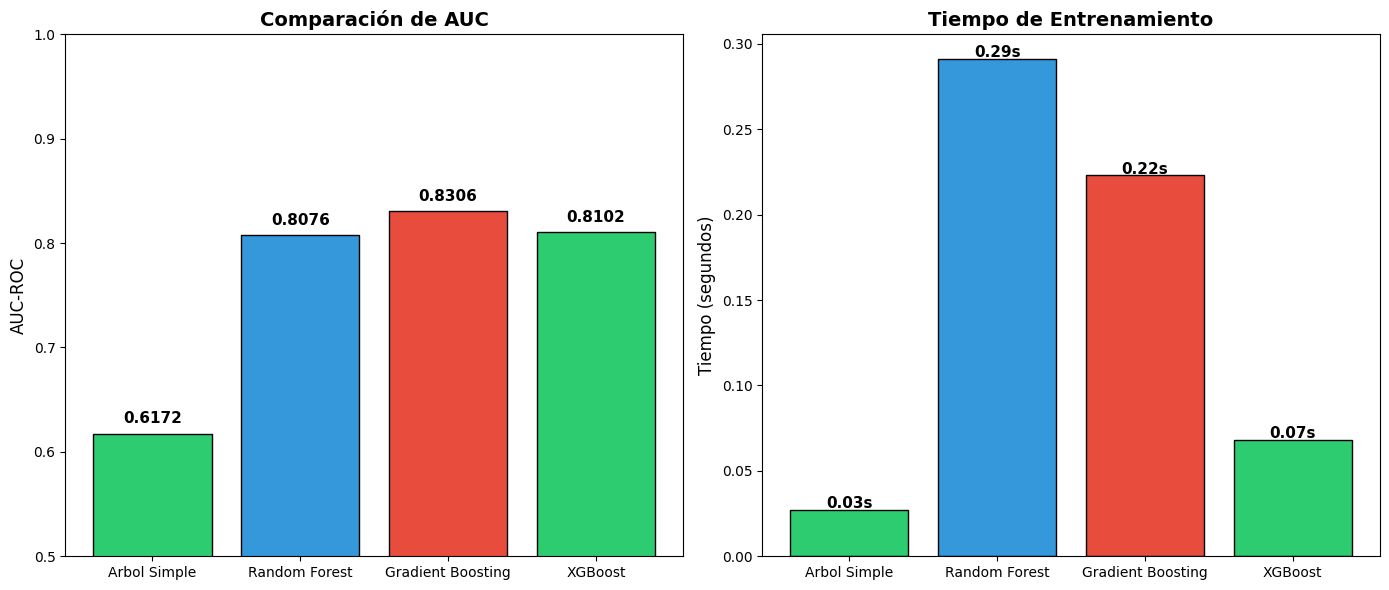

In [17]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#2ecc71', '#3498db', '#e74c3c']  # Verde, Azul, Rojo

# Gráfico 1: AUC
ax1 = axes[0]
bars1 = ax1.bar(df_results['Modelo'], df_results['AUC'],
                color=colors, edgecolor='black')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_title('Comparación de AUC', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, 1.0)
for bar, val in zip(bars1, df_results['AUC']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# Gráfico 2: Tiempo
ax2 = axes[1]
bars2 = ax2.bar(
    df_results['Modelo'], df_results['Tiempo (s)'], color=colors, edgecolor='black')
ax2.set_ylabel('Tiempo (segundos)', fontsize=12)
ax2.set_title('Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, df_results['Tiempo (s)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


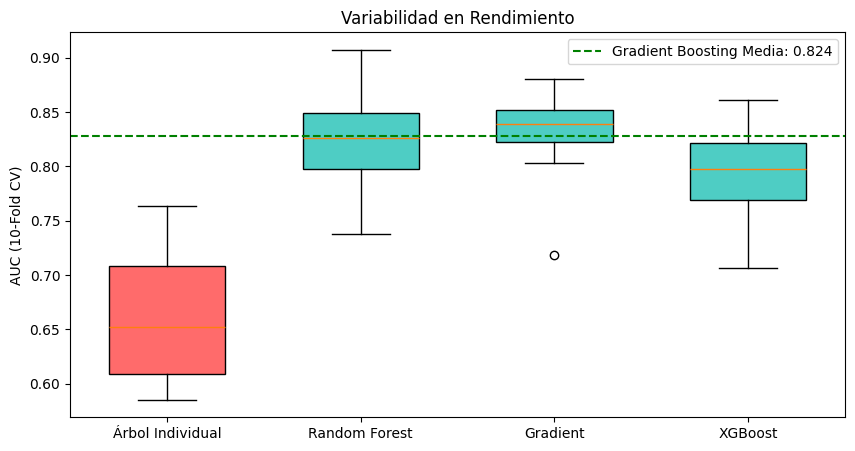

📊 Árbol_Individual: 0.663 ± 0.060
📊 Random_Forest:    0.824 ± 0.043
📊 Gradient:    0.828 ± 0.042
📊 XGBoost:    0.793 ± 0.047


In [18]:
# Comparar estabilidad con Cross-Validation
tree_scores = cross_val_score(model_TreeSimple, X, y, cv=10, scoring='roc_auc')
rf_scores = cross_val_score(model_RandomForest, X, y, cv=10, scoring='roc_auc')
gradient_scores = cross_val_score(model_Gradient, X, y, cv=10, scoring='roc_auc')
xgboost_scores = cross_val_score(model_XGBoost, X, y, cv=10, scoring='roc_auc')

fig, ax = plt.subplots(figsize=(10, 5))
positions = [1, 2, 3, 4]
bp = ax.boxplot([tree_scores, rf_scores, gradient_scores, xgboost_scores], positions=positions, widths=0.6, patch_artist=True)

colors = ['#FF6B6B', '#4ECDC4', '#4ECDC4', '#4ECDC4', '#4ECDC4']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks(positions)
ax.set_xticklabels(['Árbol Individual', 'Random Forest', 'Gradient', 'XGBoost'])
ax.set_ylabel('AUC (10-Fold CV)')
ax.set_title('Variabilidad en Rendimiento')
ax.axhline(y=np.mean(gradient_scores), color='green', linestyle='--',
           label=f'Gradient Boosting Media: {np.mean(rf_scores):.3f}')
ax.legend()
plt.show()

print(f"📊 Árbol_Individual: {np.mean(tree_scores):.3f} ± {np.std(tree_scores):.3f}")
print(f"📊 Random_Forest:    {np.mean(rf_scores):.3f} ± {np.std(rf_scores):.3f}")
print(f"📊 Gradient:    {np.mean(gradient_scores):.3f} ± {np.std(gradient_scores):.3f}")
print(f"📊 XGBoost:    {np.mean(xgboost_scores):.3f} ± {np.std(xgboost_scores):.3f}")



Considerando que el estudio quiere detectar con precisión si los pacientes tienen diabetes o no, el modelo con mejor desempeño es Gradient Boosting.  

Razones:
- mayor AUC (0.7406), mejor discrimina entre pacientes con y sin diabetes
- mayor recall de clase 1 (0.6111) detecta mejor a los pacientes con diabetes, y por tanto es menor los falsos negativos
- menor tiempo de entrenamiento (0.115 s), buen equilibrio entre rendimiento y costo computacional

<div style="color:#800080; font-size:28px; font-weight:bold;">
    6. Ajuste Manual de Hiperparámetros    
</div>

El modelo seleccionado es **Gradient Boosting** debido a que resultó ganador en la evaluación:   
🥇 Mejor Recall (Clase 1): Gradient Boosting (0.6111)  
🥇 Mejor AUC: Gradient Boosting (0.7406)

In [19]:
#Definir la grilla de hiperparámetros
param_grid = {
    'classifier__n_estimators': [1,20,50,100,200],
    'classifier__max_depth': [None, 3,5],
    'classifier__min_samples_split': [2,4],
    'classifier__min_samples_leaf': [1,2]
}

#Configurar GridSearchCV
grid_rf = GridSearchCV(
    estimator=model_Gradient,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc'
    },
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

#Entrenar GridSearch
grid_rf.fit(X_train, y_train)

#Mejores resultados
print("Mejores hiperparámetros:")
print(grid_rf.best_params_)

print("\nMejor score CV:")
print(grid_rf.best_score_)

# Mejor modelo entrenado
best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mejores hiperparámetros:
{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 20}

Mejor score CV:
0.8273525747508306


In [20]:
results = pd.DataFrame(grid_rf.cv_results_)

tabla_resultados = results[
    [
        'param_classifier__n_estimators',
        'param_classifier__max_depth',
        'param_classifier__min_samples_split',
        'param_classifier__min_samples_leaf',
        'mean_test_accuracy',
        'std_test_accuracy',
        'mean_test_roc_auc',
        'std_test_roc_auc',
        'rank_test_roc_auc'
    ]
].sort_values('rank_test_roc_auc')

# Renombrar columnas
tabla_resultados = tabla_resultados.rename(columns={
    'param_classifier__n_estimators': 'N Trees',
    'param_classifier__max_depth': 'Max Depth',
    'param_classifier__min_samples_split': 'Min Split',
    'param_classifier__min_samples_leaf': 'Min Leaf',
    'mean_test_accuracy': 'Mean Accuracy',
    'std_test_accuracy': 'Std Accuracy',
    'mean_test_roc_auc': 'Mean ROC_AUC',
    'std_test_roc_auc': 'Std ROC_AUC',
    'rank_test_roc_auc': 'Rank (ROC_AUC)'
})

print("\n📊 Resultados GridSearch Gradient:\n")
print(tabla_resultados.to_string(index=False))


📊 Resultados GridSearch Gradient:

 N Trees Max Depth  Min Split  Min Leaf  Mean Accuracy  Std Accuracy  Mean ROC_AUC  Std ROC_AUC  Rank (ROC_AUC)
      20         3          2         1       0.762282      0.026416      0.827353     0.018253               1
      20         3          4         1       0.762282      0.026416      0.825362     0.018568               2
      20         3          2         2       0.757390      0.025416      0.824680     0.019643               3
      20         3          4         2       0.757390      0.025416      0.824680     0.019643               3
      50         3          4         1       0.762295      0.036083      0.821656     0.022477               5
      50         3          2         1       0.757364      0.022295      0.819333     0.020160               6
      20         5          4         1       0.752499      0.032796      0.818893     0.023794               7
      50         3          4         2       0.750873      0.027993

El mejor modelo es 

N Trees = 20
Max Depth = 3
Min Split = 2
Min Leaf = 1
Mean ROC_AUC = 0.827353
Std ROC_AUC  = 0.018253

Este modelo alcanzó el mayor valor promedio de AUC (0.827) y, al mismo tiempo, presentó una baja variabilidad (desviación estándar de 0.018), lo que indica un desempeño estable a lo largo de las particiones de validación cruzada.

En comparación con otras configuraciones evaluadas, los modelos con un mayor número de árboles o mayor profundidad no mostraron mejoras sustanciales en el AUC, e incluso en algunos casos presentaron una mayor variabilidad. 
Al aumentar el número de árboles de 20 a 50, 100 y 200, no se observa una mejora consistente en el AUC.
Los mejores modelos se obtienen con una profundidad máxima de 3. Cuando la profundidad aumenta a 5 o se deja sin límite (None), el AUC disminuye notablemente y la variabilidad aumenta.
Valores moderados de min_samples_split (2 o 4) producen resultados similares.
Los mejores resultados se obtienen con 1 observación por hoja, lo que permite mayor detalle en las predicciones finales.Al aumentar min_samples_leaf a 2, el AUC disminuye ligeramente, indicando una pérdida de capacidad discriminativa.



<div style="color:#800080; font-size:28px; font-weight:bold;">
    7. Interpretabilidad
</div>

**Feature Importance**

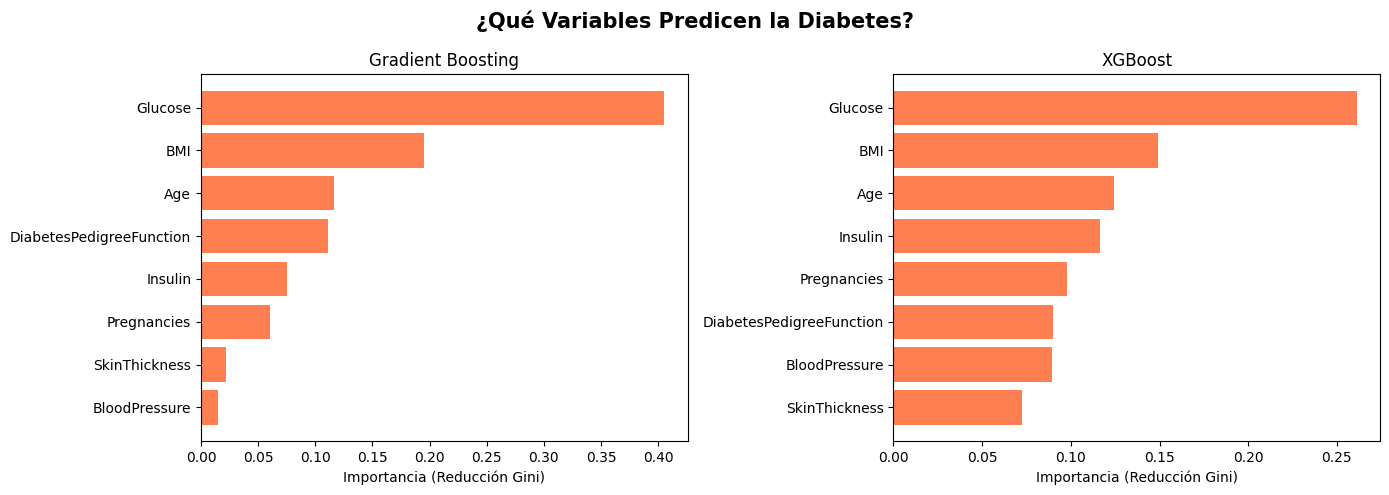

🔍 La variable Glucosa es la mas importantes, y el BMI es un factor de riesgo, las demas podrían no intervenir en la decision de diabetes.


In [21]:
# Obtener nombres de las características
feature_names = model_Gradient.named_steps['preprocessor'].get_feature_names_out()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---------- Gradient Boosting ----------
importances_gb = model_Gradient.named_steps['classifier'].feature_importances_
indices_gb = np.argsort(importances_gb)[::1]  # Ordena de mayor a menor

axes[0].barh(
    range(len(feature_names)),
    importances_gb[indices_gb],
    color='coral'
)
axes[0].set_yticks(range(len(feature_names)))  # Asegura que haya el mismo número de ticks
axes[0].set_yticklabels([feature_names[i] for i in indices_gb])  # Etiquetas correspondientes
axes[0].set_xlabel('Importancia (Reducción Gini)')
axes[0].set_title('Gradient Boosting')

# ---------- XGBoost ----------
importances_xgb = model_XGBoost.named_steps['classifier'].feature_importances_
indices_xgb = np.argsort(importances_xgb)[::1]  # Ordena de mayor a menor

axes[1].barh(
    range(len(feature_names)),
    importances_xgb[indices_xgb],
    color='coral'
)
axes[1].set_yticks(range(len(feature_names)))  # Asegura que haya el mismo número de ticks
axes[1].set_yticklabels([feature_names[i] for i in indices_xgb])  # Etiquetas correspondientes
axes[1].set_xlabel('Importancia (Reducción Gini)')
axes[1].set_title('XGBoost')

plt.suptitle('¿Qué Variables Predicen la Diabetes?', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("🔍 La variable Glucosa es la mas importantes, y el BMI es un factor de riesgo, las demas podrían no intervenir en la decision de diabetes.")

**Visualización del árbol**

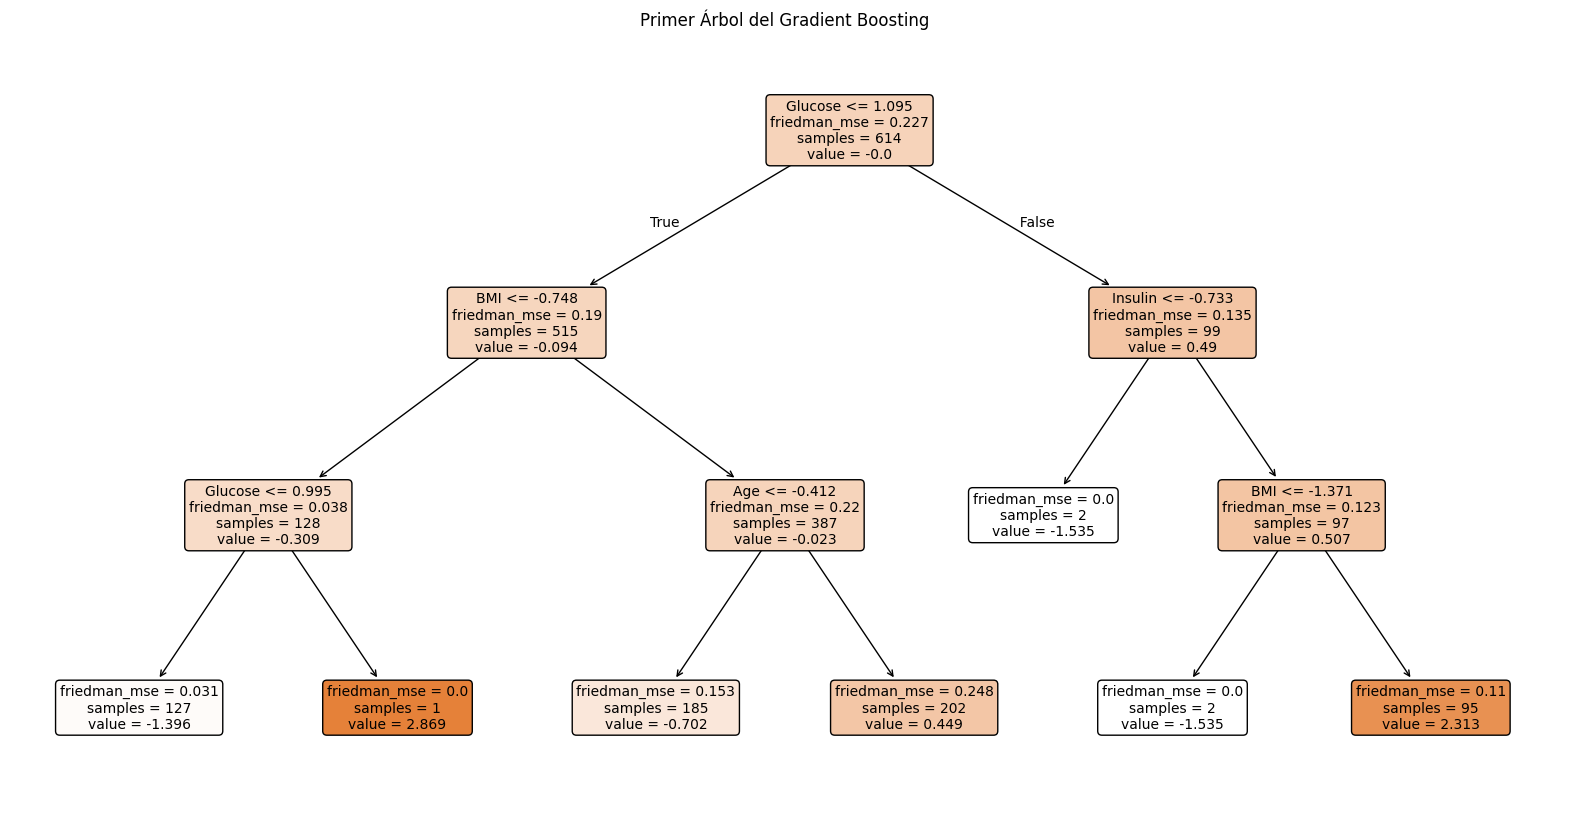

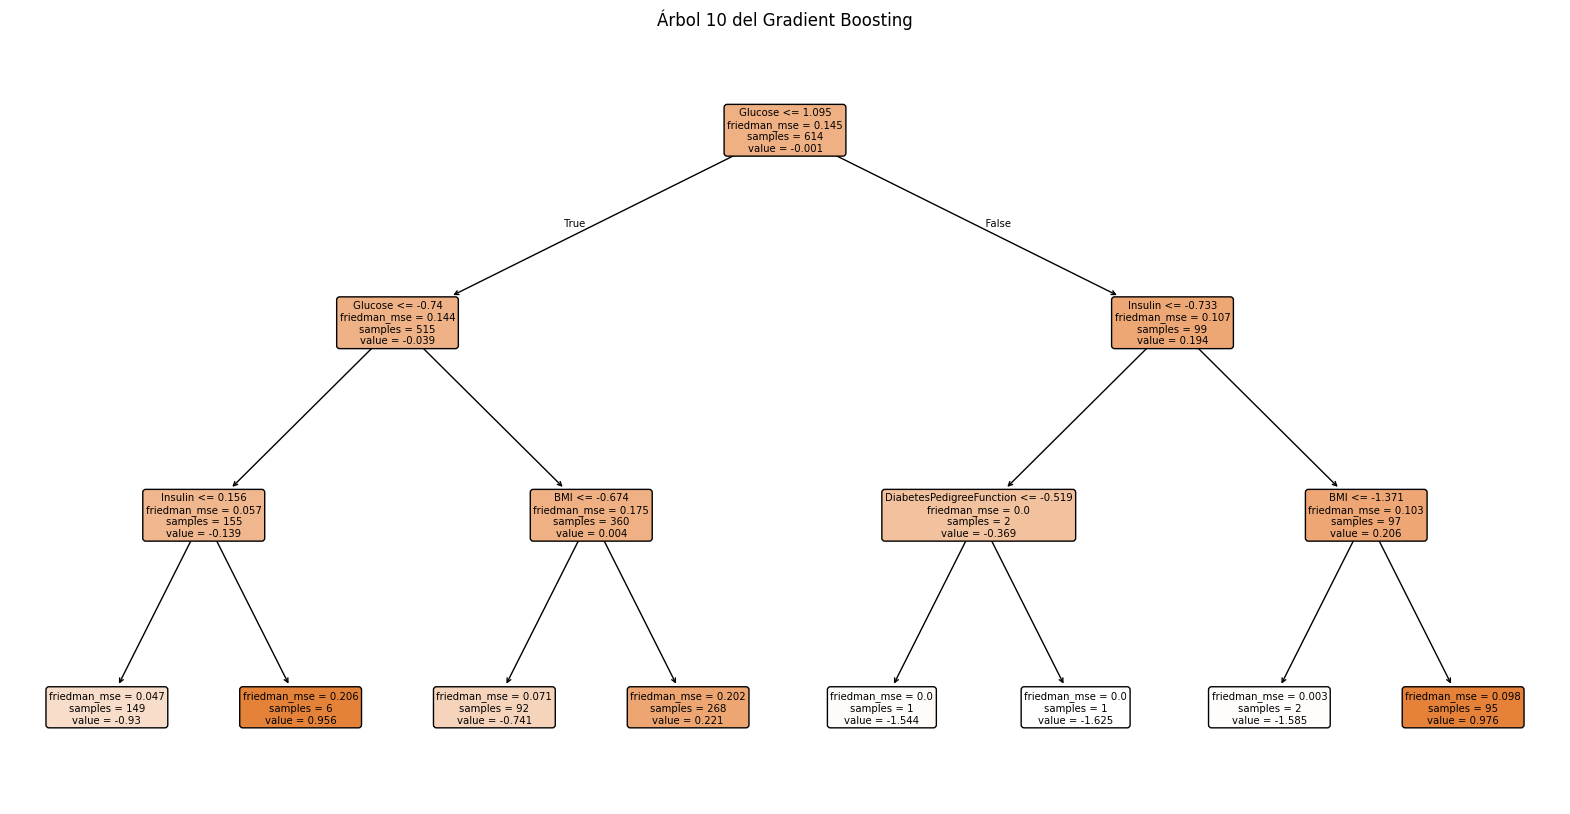

In [22]:
# Extraer el clasificador Gradient Boosting
gb_clf = model_Gradient.named_steps['classifier']

# Seleccionar un árbol (ej. el primero)
tree = gb_clf.estimators_[0, 0]

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=["No Diabetes", "Diabetes"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Primer Árbol del Gradient Boosting")
plt.show()

tree = gb_clf.estimators_[10, 0]

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=["No Diabetes", "Diabetes"],
    filled=True,
    rounded=True
)
plt.title("Árbol 10 del Gradient Boosting")
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
    8. Conclusiones
</div>

**¿Qué modelo recomiendas para producción y por qué?**  
El modelo que se recomienda es Gradient Boosting 
El modelo GRadient con 20 árboles y profundidad máxima de 3 se considera el modelo óptimo, ya que logra el mejor equilibrio entre capacidad predictiva, estabilidad y simplicidad, siendo el más adecuado para la predicción de diabetes en este estudio. 

**Trade-offs observados (accuracy vs interpretabilidad, tiempo de entrenamiento, etc.)**  
El modelo Gradient Boosting es el mejor para predecir los casos de diabetes que es lo que pide el estudio, sin embargo es complejo al momento de la interpretación directa de los resultados, ya que las decisiones no se basan en reglas simples, sino en la combinación de múltiples árboles secuenciales. Esto limita la comprensión intuitiva de cómo cada variable contribuye individualmente a la predicción.
Ademas, este mejor rendimiento se logra a costa de un mayor tiempo de entrenamiento, a comparación de los modelos de arbol de decisión y XGBoost.

**Próximos pasos sugeridos:**  
Continuar evaluando el Dataset con técnicas que permitan optimizar y calibar el modelo.


<div style="color:#800080; font-size:28px; font-weight:bold;">
    9. Referencias
</div>

El caso se ha tomado de kaggle:  


https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

<div style="color:#800080; font-size:28px; font-weight:bold;">
    10. Serialización y Producción (Adicional)
</div>

**Como punto adicional, se ha generado el joblib y se realizó el deploy en producción con el modelo Gradient Boosting. Para su Verificación se puede realizar desde el siguiente link:**

https://pecd-supervisado-ctrl2.streamlit.app/


In [23]:
import sys
import os
import json
import sklearn

# ========================================
# MÉTODO 2: JOBLIB (Estándar ML)
# ========================================
joblib_path = '../app/models/model_joblib.joblib'
auc = roc_auc_score(y_test, model_Gradient.predict_proba(X_test)[:, 1])

# Guardar CON metadatos (buena práctica)
artifact = {
    'model': model_Gradient,
    'feature_names': X.columns.tolist(),
    'target_col': TARGET_COL,
    'auc_test': auc,
    'training_date': pd.Timestamp.now().isoformat(),
    'python_version': sklearn.__version__
    #'lightgbm_version': lgb.__version__
}

start = time.time()
joblib.dump(artifact, joblib_path, compress=3)  # compress=3 es buen balance
joblib_save_time = time.time() - start

# Cargar
start = time.time()
loaded_artifact = joblib.load(joblib_path)
joblib_load_time = time.time() - start

model_joblib = loaded_artifact['model']

# Verificar
pred_joblib = model_joblib.predict_proba(X_test)[:, 1]
auc_joblib = roc_auc_score(y_test, pred_joblib)

joblib_size = os.path.getsize(joblib_path) / 1024

print(f"📁 Archivo: {joblib_path}")
print(f"📦 Tamaño: {joblib_size:.2f} KB (comprimido)")
print(f"⏱️ Tiempo guardar: {joblib_save_time*1000:.2f} ms")
print(f"⏱️ Tiempo cargar: {joblib_load_time*1000:.2f} ms")
print(f"✅ AUC verificado: {auc_joblib:.4f}")
print(f"\n📋 Metadatos guardados: {list(loaded_artifact.keys())}")

📁 Archivo: ../app/models/model_joblib.joblib
📦 Tamaño: 41.67 KB (comprimido)
⏱️ Tiempo guardar: 14.14 ms
⏱️ Tiempo cargar: 33.83 ms
✅ AUC verificado: 0.8306

📋 Metadatos guardados: ['model', 'feature_names', 'target_col', 'auc_test', 'training_date', 'python_version']


In [24]:
# ========================================
# MÉTODO 5B: JSON + Metadatos (Para APIs)
# ========================================
json_path = '../app/models/model_metadata.json'

# Guardar metadatos en JSON (legible por cualquier lenguaje)
metadata = {
    'model_type': 'Gradient Boosting',
    'model_file': 'model_texto.txt',
    'feature_names': X.columns.tolist(),
    'n_features': len(X.columns.tolist()),
    'target_col': TARGET_COL,
    
    'metrics': {
        'auc_test': round(auc, 4),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    },
    
    'training_info': {
        'date': pd.Timestamp.now().isoformat(),
        'version': sklearn.__version__        
    }
}

with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"📁 Metadatos guardados: {json_path}")
print(f"\n📋 Contenido:")
print(json.dumps(metadata, indent=2)[:1000] + "...")

📁 Metadatos guardados: ../app/models/model_metadata.json

📋 Contenido:
{
  "model_type": "Gradient Boosting",
  "model_file": "model_texto.txt",
  "feature_names": [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
  ],
  "n_features": 8,
  "target_col": "Outcome",
  "metrics": {
    "auc_test": 0.8306,
    "n_train_samples": 614,
    "n_test_samples": 154
  },
  "training_info": {
    "date": "2025-12-13T23:01:35.116486",
    "version": "1.7.2"
  }
}...
